In [ ]:
# install these libraries before proceeding
# !pip3 install numpy
# !pip3 install pandas
# !pip3 install wordcloud
# !pip3 install nltk
# !pip3 install matplotlib
# !pip3 install nltk

In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
from collections import Counter
from collections import OrderedDict
import re
import os

In [2]:
# uncomment the below line to download english stopwords
#nltk.download('stopwords')

## Util 

In [3]:
def custom_display(txt):
    display(HTML("<h2>" + txt + "</h2>"))
    print("_____"*23)

def sort_by_values(data, reverse=True):
    return OrderedDict(sorted(data.items(), key=lambda t: t[1], reverse=True))

def plot_bar_chart(total_items, y_values, x_values, title, xlabel, ylabel, rotation=0):
    plt.figure(figsize=(18,10))
    plt.bar(np.arange(total_items), y_values,color=['violet','indigo','blue','green', 'yellow', 'orange','red' ])
    plt.xticks(np.arange(total_items),x_values,rotation=rotation)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

def get_regex_user_name(name):
    return name.replace(' ', '\s').replace('|', '\|')

In [4]:
file_name = 'WhatsApp Chat with AppliedAI.txt' # '_chat.txt'# # replace the file name by your file name/path
fh = open(file_name,"r",encoding="utf8")
original_data = fh.read()
is_iphone = original_data[0] == '['

In [5]:
data =''.join([x for x in original_data if ( (x == '\n') or (ord(x) < 128 and ord(x)) > 31)])

## Getting datetime & user name from the text file

In [6]:
def get_date_time_user_name_data():
    date_time_user_name = [] # will be array of ('19/02/18', '23:28:00', 'Kalsi')
    if is_iphone:
        time_and_names = re.findall(r'(\[\d{2}/\d{2}/\d{2},\s\d{1,2}:\d{1,2}:\d{1,2}\]\s.*?:)', data)[1:] # skipping first line
        # time_and_names is array of type "[02/07/18, 12:59:07] user_name:"
        for time_name in time_and_names:
            t = time_name.split(']')
            date_time = t[0][1:]
            date_ = date_time.split(',')[0].strip() #02/07/18, dd/mm/yy
            time_ = date_time.split(',')[1].strip() #12:59:07
            user_name = t[1][:-1].strip().replace('\xa0', ' ')
            date_time_user_name.append((date_,time_, user_name ))
    else:
        time_and_names = re.findall(r'(\d{2}/\d{2}/\d{2},\s\d{1,2}:\d{1,2}\s(PM|AM)\s-\s.*?:)', data)
        #time_and_names is an array of type ('19/02/18, 9:44 PM - user_name:', 'PM'),
        for time_name, meridian in time_and_names:
            date_time = time_name.split(' - ')[0] # 19/02/18, 9:44 PM
            name_ = time_name.split(' - ')[1][:-1] # remove the last character i.e, ':' to get the user_name
            date_ = date_time.split(', ')[0]# 19/02/18
            time_ = date_time.split(', ')[1].split(' ')[0] # 9:44
            hour_ = int(time_.split(':')[0])
            minute_ = time_.split(':')[1]
            if (meridian == 'PM'):# and (hour_ != 12):
                hour_ += 12
            hour_ -= 1
            if hour_ < 10:
                hour_ = "0"+str(hour_)
            final_time = str(hour_) + ":" + str(minute_) + ":00"   
            date_time_user_name.append((date_,final_time, name_ ))
    return date_time_user_name

def get_message_timings():
    users = {}
    message_timings = {}
    date_time_user_name = get_date_time_user_name_data()
    for date_, time_, name_ in date_time_user_name:
#         name_ = name_.strip('\u202c').strip('\u202a')
        if name_ in users.keys():
            users[name_]+=1
        else:
            users[name_]=1
        hour = time_.split(':')[0]
        if hour not in message_timings.keys():
            message_timings[hour] = 0
        message_timings[hour] += 1
    return users, message_timings

In [7]:
users,message_timings = get_message_timings()

## Peak hour of chat

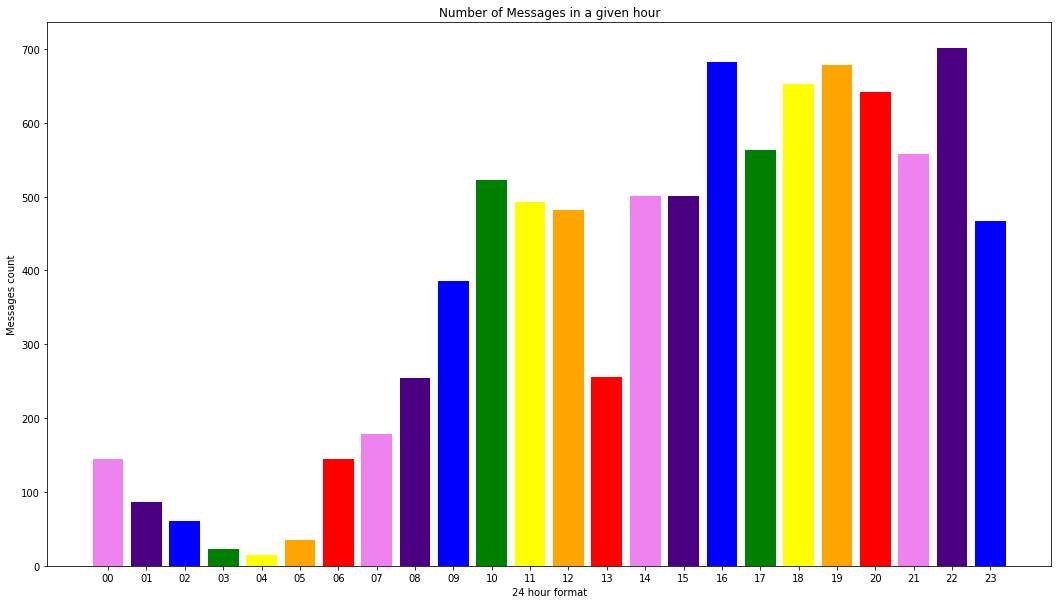

___________________________________________________________________________________________________________________


In [8]:
hours = sorted(message_timings.keys())
message_counts = [message_timings[hour] for hour in hours]
plot_bar_chart(len(hours), message_counts, hours, 'Number of Messages in a given hour', '24 hour format', 'Messages count')
custom_display("Chats will be more during " + str(hours[np.argmax(message_counts)]) + ":00 hours")

# Frequency of messages by Users

In [9]:
users_df = pd.DataFrame({'id': np.arange(len(users.keys())), 'user':list(users.keys()), 'messages':list(users.values())})
users_df=users_df.sort_values(['messages'], ascending=False)
total_active_users = users_df.shape[0]

In [10]:
total_msgs = users_df.messages.sum(axis=0)
if is_iphone:
    total_medias = len(re.findall(r'image omitted', data)) + len(re.findall(r'video omitted', data))
else:
    total_medias = len(re.findall(r'<Media omitted>', data))
hyper_links = re.findall(r'(http[s]?://[^\s\n]+)', data)

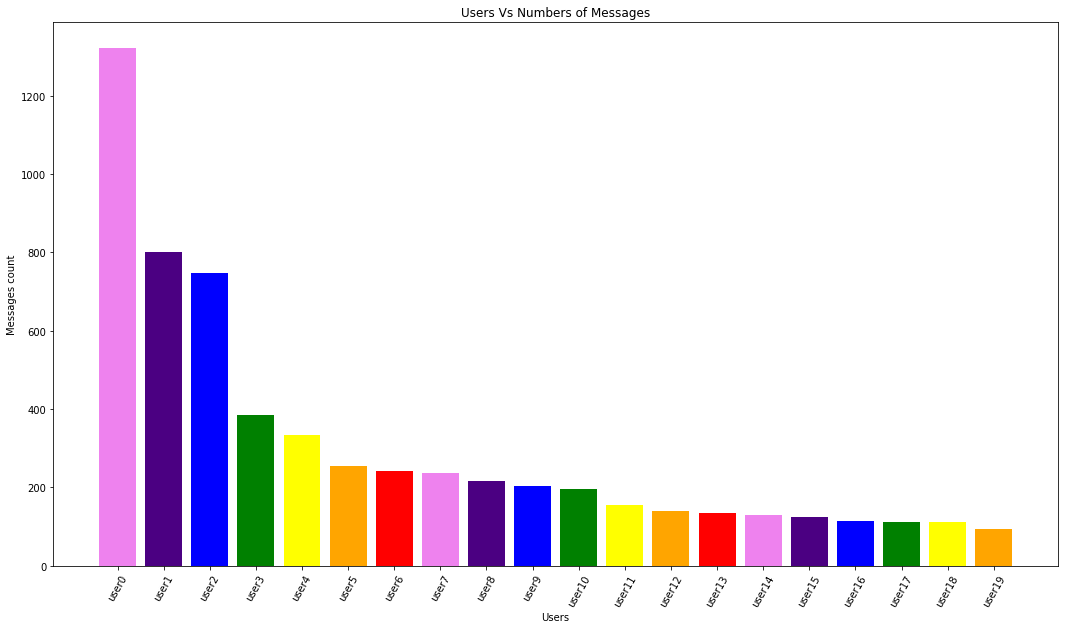

___________________________________________________________________________________________________________________


In [34]:
number_of_users_to_be_shown = 20
message_count_by_users = users_df.messages[:number_of_users_to_be_shown].tolist()
user_names = users_df.user[:number_of_users_to_be_shown].tolist()
number_of_users_to_be_shown = min(number_of_users_to_be_shown, total_active_users)
# user_names = []
# for i in range(number_of_users_to_be_shown):
#     user_names.append('user'+str(i))
plot_bar_chart(number_of_users_to_be_shown, message_count_by_users, user_names, 'Users Vs Numbers of Messages', 'Users', 'Messages count', rotation=60)
# custom_display("User X" + " messaged highest number of times with "+ str(users_df['messages'].iloc[0])+ " messages which is "+ str(round((users_df['messages'].iloc[0]/total_msgs)*100.0,2))+"% of the total messages")
custom_display(users_df['user'].iloc[0] + " messaged highest number of times with "+ str(users_df['messages'].iloc[0])+ " messages which is "+ str(round((users_df['messages'].iloc[0]/total_msgs)*100.0,2))+"% of the total messages")

In [12]:
custom_display("Total active users: "+ str(total_active_users))
custom_display("Total messages: "+ str(total_msgs))
custom_display("Total medias shared: "+ str(total_medias))
custom_display("Total  hyper links: "+ str(len(hyper_links)))
# uncomment the following lines to get the hyper links
# for link in hyper_links:
#     print(link)

___________________________________________________________________________________________________________________


___________________________________________________________________________________________________________________


___________________________________________________________________________________________________________________


___________________________________________________________________________________________________________________


In [13]:
user_contents = []
for user_name in users_df['user']:
    user_id = int(users_df[users_df['user'] == user_name]['id'])
    if user_name[0] == '+':
        user_name = '\\' +  user_name
    else:
        user_name = get_regex_user_name(user_name)
    user_name = user_name.replace('(','\(').replace(')', '\)')
    contents = []
    if is_iphone:
        contents = re.findall(r''+user_name+ ':((?:.*?\r?\n?)*)(\[)', data)
    else:
        contents = re.findall(r''+user_name+ ':(.*)', data)
    for content in contents:
        if is_iphone:
            content = content[0]
        if len(content.strip()) > 0:
            user_contents.append([user_id, content.strip()])

In [14]:
content_df = pd.DataFrame(user_contents,  columns=['user_id', 'message'])
content_df['message_length'] = content_df['message'].apply(lambda x: len(x))
content_df.head()

,user_id,message,message_length
0,1,Yes,3
1,1,I have done.,12
2,1,https://youtu.be/n92U_y5PwhU,28
3,1,fact,4
4,1,https://awwcart.wooplr.com,26


In [35]:
long_content = content_df[content_df.message_length == max(content_df.message_length)]
longest_message = long_content['message'].tolist()[0]
user_name = users_df[users_df['id'] == int(long_content['user_id'])]['user'].tolist()[0]
# custom_display("User X " + " wrote the longest message with " + str(len(longest_message.split()))+" words \n"+ '====='*20+ '\n')
custom_display(user_name + " wrote the longest message with " + str(len(longest_message.split()))+" words \n"+ '====='*20+ '\n')
print(longest_message)
custom_display('====='*20)

___________________________________________________________________________________________________________________
Suppose you have a dataset with 25 features, but you decide you dont want to analyze all those 25 features, you just want one number to do all the job. The most simple solution is that for each data point, you take an average of those 25 feature values, and get just one number to get the job done. But here you realize that youre giving equal importance to all the 25 values while practically some of them might be more important than others, they need to be given more importance and the useless ones need to be given less importance. So you decide to do a weighted average of those 25 values, youll basically give more weight to the important features and less weight to the useless ones. Now you cant manually assign weights for each feature, because  you do not know which ones are important and you also do not care about finding that out yourself. You just want a set of weight

___________________________________________________________________________________________________________________


## Word Cloud

In [16]:
english_words = set(stopwords.words('english'))
content_df['message_modified'] = content_df['message'].apply(lambda txt: ' '.join(t for t in txt.lower().strip().split() if t not in english_words))
word_cloud_text = ' '.join(content_df['message_modified']) # ' '.join(content_df['message_modified'].apply(lambda x: ''.join(x).strip()).tolist())
word_cloud_text = str(word_cloud_text.encode('ascii','ignore'))

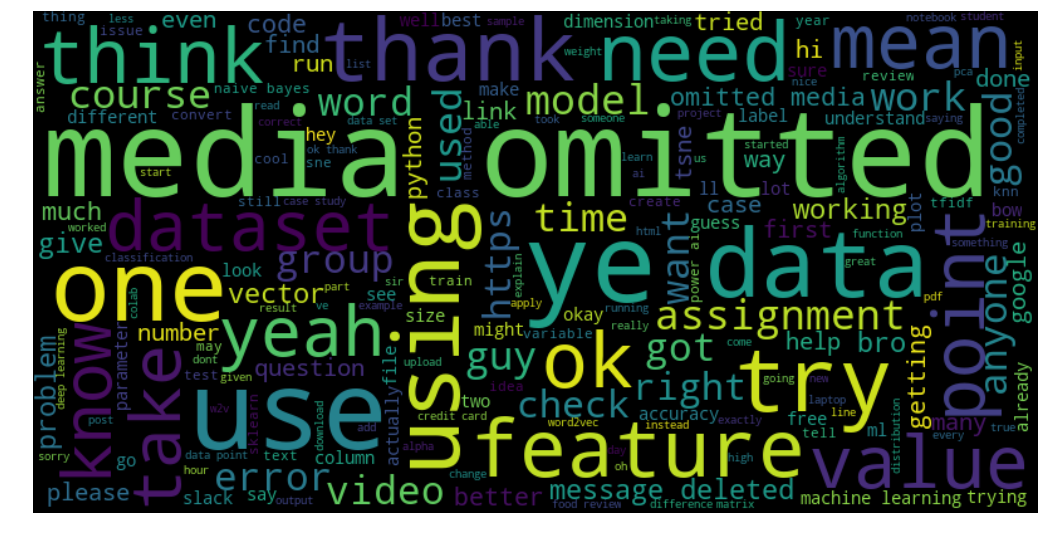

In [17]:
wordcloud = WordCloud(width=800, height=400).generate(word_cloud_text)
plt.figure(figsize=(18,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Top 3 most commonly used words

In [18]:
def replace_multiple_words(text,words_to_be_replaced, replaced_by):
    for word in words_to_be_replaced:
        text = text.replace(word, " "+replaced_by+" ")
    return ' '.join(text.split())

In [19]:
media_types = ["<media omitted>", 'image omitted', 'video omitted']
whole_text_list = replace_multiple_words(word_cloud_text,media_types, 'forwarded_media').split(' ') #.replace("<media omitted>", "forwarded_media").replace('image omitted','forwarded_media').replace('video omitted','forwarded_media').split(' ')
whole_text = Counter(whole_text_list)
custom_display(str(whole_text.most_common(3)))

___________________________________________________________________________________________________________________


## Frquency of Medias (Image or Video) sent by users 

In [20]:
def get_media_count(user_id):
    return content_df[(content_df['user_id'] == user_id) & content_df['message_modified'].str.contains('|'.join(media_types))].shape[0]
users_df['total_media_sent'] = [get_media_count(user_id) for user_id in users_df.id.tolist()]

In [21]:
temp_users_df = users_df.sort_values(['total_media_sent'], ascending=False)
total_medias_sent = users_df.total_media_sent.sum().tolist()
custom_display("Total media shared: "+ str(total_medias_sent))

___________________________________________________________________________________________________________________


___________________________________________________________________________________________________________________


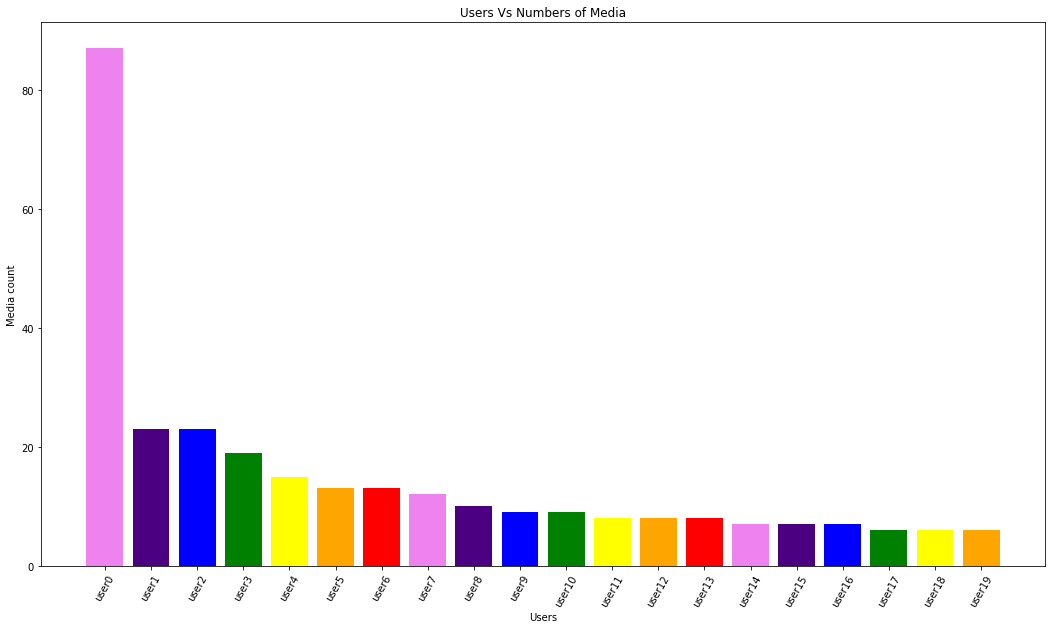

In [36]:
#custom_display("User X" + " has sent highest number of medias with a count of "+ str(temp_users_df['total_media_sent'].iloc[0])+ " medias which is "+ str(round((users_df['total_media_sent'].iloc[0]/total_medias_sent)*100.0,2))+"% of the total medias")
custom_display(temp_users_df['user'].iloc[0] + " has sent highest number of medias with a count of "+ str(temp_users_df['total_media_sent'].iloc[0])+ " medias which is "+ str(round((users_df['total_media_sent'].iloc[0]/total_medias_sent)*100.0,2))+"% of the total medias")
media_count_by_users = temp_users_df.total_media_sent[:number_of_users_to_be_shown].tolist()
user_names = temp_users_df.user[:number_of_users_to_be_shown].tolist()
# user_names = []
# for i in range(number_of_users_to_be_shown):
#     user_names.append('user'+str(i))

plot_bar_chart(number_of_users_to_be_shown, media_count_by_users, user_names, 'Users Vs Numbers of Media', 'Users', 'Media count', rotation=60)

In [23]:
# to get messages by a specific user
# re.findall(r'(\d{2}/\d{2}/\d{2},\s\d{1,2}:\d{1,2}\s(PM|AM)\s-\s'+user_name+ ':+)', data)

## Smiley Analysis

In [24]:
smileys = '😀😃😄😁😆😅😂🤣😊😇🙂🙃😉😌😍😘😗😙😚😋😛😝😜🤪🤨🧐🤓😎🤩😏😒😞😔😟😕🙁😣😖😫😩😢😭😤😠😡🤬🤯😳😱😨😰😥😓🤗🤔🤭🤫🤥😶😐😑😬🙄😯😦😧😮😲😴🤤😪😵🤐🤢🤮🤧😷🤒🤕🤑🤠😈👿👹👺🤡💩👻💀☠👽👾🤖🎃😺😸😹😻😼😽🙀😿😾🤲👐🙌👏🤝👍👎👊✊🤛🤜🤞✌🤟👌👈👉👆☝✋🤚🖐🖖👋🤙💪🖕✍🙏💍💄💋👄👅👂👃👣👁👀🧠🗣👤👥👶👧🧒👦👩🧑👨🧔👵🧓👴🙇‍💁‍💁‍🙅‍🙅‍🙆‍🙆‍🙋‍🙋‍🤦‍🤦‍🤷‍🤷‍🙎‍🙎‍🙍‍🙍‍💇‍💇‍💆‍💆‍🧖‍🧖‍💅🤳💃🕺👯‍👯‍🕴🚶‍🚶‍🏃‍🏃‍👫👭👬💑👩‍❤‍👩👨‍❤‍👨💏👩‍💋‍👩👨‍💋‍👪👨‍👩‍👧👨‍👩‍👧‍👦👨‍👩‍👦‍👦👨‍👩‍👧‍👧👩‍👩‍👦👩‍👩‍👧👩‍👩‍👧‍👦👩‍👩‍👦‍👦👩‍👩‍👧‍👧👨‍👨‍👦👨‍👨‍👧👨‍👨‍👧‍👦👨‍👨‍👦‍👦👨‍👨‍👧‍👧👩‍👦👩‍👧👩‍👧‍👦👩‍👦‍👦👩‍👧‍👧👙👑🐶🐵🙈🙉🙊🐒🌹⚽🏋‍🏋‍🤼‍🤼‍❤💔❣🧡💛💚💙💜💕💞💓💗💖💘💝💟✝☪🕉☸✡🔯💯'

In [25]:
smiley_data = {}
for smiley in smileys:
    cnt = len(re.findall(r'' + smiley+ '', original_data))
    if cnt > 0:
        smiley_data[smiley]=cnt

In [26]:
ordered_smileys_by_usage_dict = sort_by_values(smiley_data)
smileys_count_list = list(ordered_smileys_by_usage_dict.values())
total_smileys_used = sum(smileys_count_list)
custom_display("Total smileys sent: "+ str(total_smileys_used))

___________________________________________________________________________________________________________________


In [27]:
top_n_smileys=10
if total_smileys_used > 0:
    top_n_smileys_percentage = np.round((sum(smileys_count_list[:top_n_smileys])/total_smileys_used)*100.0)
    display(HTML(("<h2>Top "+ str(top_n_smileys) + " used smileys:</h2>")))
    print(list(ordered_smileys_by_usage_dict.keys())[:top_n_smileys])
    top_n_smileys_percentage = np.round((sum(smileys_count_list[:top_n_smileys])/total_smileys_used)*100.0)
    custom_display("And these smileys constitute " + str(top_n_smileys_percentage)+ "% of the total smileys sent")

['👍', '😂', '😅', '👆', '👌', '🤣', '🤔', '😊', '😁', '😀']


___________________________________________________________________________________________________________________


In [28]:
html_table = """
<table style="font-family: arial, sans-serif;border-collapse: collapse;width: 100%;">
    <tbody>
        <tr>
            <th style='border: 1px solid #dddddd;text-align: left;padding: 8px;'>Smiley</th>
            <th style='border: 1px solid #dddddd;text-align: left;padding: 8px;'> Percentage </th>
        </tr>            
"""
for smiley in list(ordered_smileys_by_usage_dict.keys())[:top_n_smileys]:
    html_table += "<tr>"
    html_table += "<td style='border: 1px solid #dddddd;text-align: left;padding: 8px;'>" + str(smiley) + "</td>"
    html_table += "<td style='border: 1px solid #dddddd;text-align: left;padding: 8px;'>" + str(round((ordered_smileys_by_usage_dict[smiley]/total_smileys_used)*100.0, 3)) + "%</td>"
    html_table += "</tr>"
html_table += "</tbody></table>"
display(HTML(html_table))

Smiley,Percentage
👍,18.162%
😂,16.86%
😅,15.847%
👆,6.223%
👌,5.933%
🤣,5.861%
🤔,2.894%
😊,2.533%
😁,2.243%
😀,2.098%


# Tag analysis

In [29]:
tagged_people_count = {} # 'contact_number': count
people_who_tags_others = {} # 'contact_number': [contact_number, contact_number]

In [30]:
for user_id in users_df.id:
    messages = ' '.join(content_df[content_df['user_id'] == user_id]['message_modified'].tolist())
    tags = [txt[1:] for txt in re.findall(r'@\d{8,15}', messages)]
    contact_name = users_df[users_df['id'] == user_id]['user'].tolist()[0]
    if len(tags) > 0:
        tagged_people_count[contact_name] = len(tags)
        people_who_tags_others[contact_name] = tags

In [31]:
tagged_people_count = sort_by_values(tagged_people_count)
total_tag_count = sum(list(tagged_people_count.values()))

## Top users who tags others 

In [38]:
top_users_count = 3
html_table = """
<table style="font-family: arial, sans-serif;border-collapse: collapse;width: 100%;">
    <tbody>
        <tr>
            <th style='border: 1px solid #dddddd;text-align: left;padding: 8px;'>Name</th>
            <th style='border: 1px solid #dddddd;text-align: left;padding: 8px;'> Tag count </th>
        </tr>            
"""
for user_name in list(tagged_people_count.keys())[:top_users_count]:
    html_table += "<tr>"
    html_table += "<td style='border: 1px solid #dddddd;text-align: left;padding: 8px;'>" + user_name + "</td>"
    html_table += "<td style='border: 1px solid #dddddd;text-align: left;padding: 8px;'>" + str(tagged_people_count[user_name]) + " ("+ str(np.round((tagged_people_count[user_name]/total_tag_count)*100.0, 2))+"% of total tags)</td>"
    html_table += "</tr>"
html_table += "</tbody></table>"

people_who_are_tagged_in_chats = []
for key in people_who_tags_others.keys():
    people_who_are_tagged_in_chats+= people_who_tags_others[key]

In [39]:
tag_count = sort_by_values(Counter(people_who_are_tagged_in_chats))
most_tagged_contact = list(tag_count)[0]

custom_display("Total tags: " + str(total_tag_count))
display(HTML("<h3>Top list of users who tags others</h3><br>" + html_table))
custom_display(str(most_tagged_contact) + " is the most tagged person with a tag count of " + str(tag_count[most_tagged_contact]) + " which is " + str(np.round((tag_count[most_tagged_contact]/total_tag_count)*100.0, 2)) + "% of the total tags" )
# custom_display("User X" + " is the most tagged person with a tag count of " + str(tag_count[most_tagged_contact]) + " which is " + str(np.round((tag_count[most_tagged_contact]/total_tag_count)*100.0, 2)) + "% of the total tags" )

___________________________________________________________________________________________________________________


Name,Tag count
user_name,17 (22.08% of total tags)
user_name,11 (14.29% of total tags)
user_name,7 (9.09% of total tags)


___________________________________________________________________________________________________________________
